In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pandas_datareader.data as web

In [2]:
now = pd.datetime.now()

In [3]:
years = [2013, 2014, 2015, 2016]

In [4]:
dates = pd.date_range('2016-01-01', '2016-12-31')
date_str = []
for date in dates:
    date_str.append('{:02d}-{:02d}'.format(date.month, date.day))

In [5]:
com = {}

In [6]:
code = 'AJL.AX'

In [7]:
dat = web.DataReader(code, 'yahoo', pd.datetime(years[0], 1, 1), pd.datetime.now())

In [8]:
for year in years:
    first_day = str(year)+'-01-01'
    last_day = str(year)+'-12-31'
    com[year] = dat.loc[first_day:last_day, 'Close'].copy()
    com[year] = com[year].reset_index()
    com[year].loc[:, 'Date'] = (
        com[year].loc[:, 'Date'].apply(
            lambda x: '{:02d}-{:02d}'.format(x.month, x.day)
        )
    )
    com[year] = com[year].set_index('Date')
    com[year] = com[year].reindex(index=date_str)
    com[year].columns = [year]

In [9]:
price = pd.concat([value for key, value in com.items()], axis=1)
price = price.fillna(method='ffill')
next_day = '{:02d}-{:02d}'.format(now.month, now.day)
price.loc[next_day:'12-31', years[-1]] = np.nan

In [10]:
price.tail()

,2016,2013,2014,2015
Date,,,,
12-27,NaN,1.02331,0.72684,0.33473
12-28,NaN,1.02331,0.72684,0.33473
12-29,NaN,1.02331,0.73640,0.33473
12-30,NaN,1.02331,0.73640,0.33473
12-31,NaN,1.05200,0.73640,0.33473


In [11]:
div_dat = web.DataReader(
    name=code,
    data_source='yahoo-actions',
    start=pd.datetime(years[0], 1, 1),
    end=now,
)
if not div_dat.empty:
    div_dat = div_dat.loc[(div_dat.action == 'DIVIDEND').values]

In [12]:
xticks = []
for month in range(1, 13):
    xticks.append('{:02d}-01'.format(month))

In [13]:
xlocs = []
for date in xticks:
    xlocs.append(date_str.index(date))

In [14]:
colors = plt.cm.Spectral(np.linspace(0, 1, len(years)))

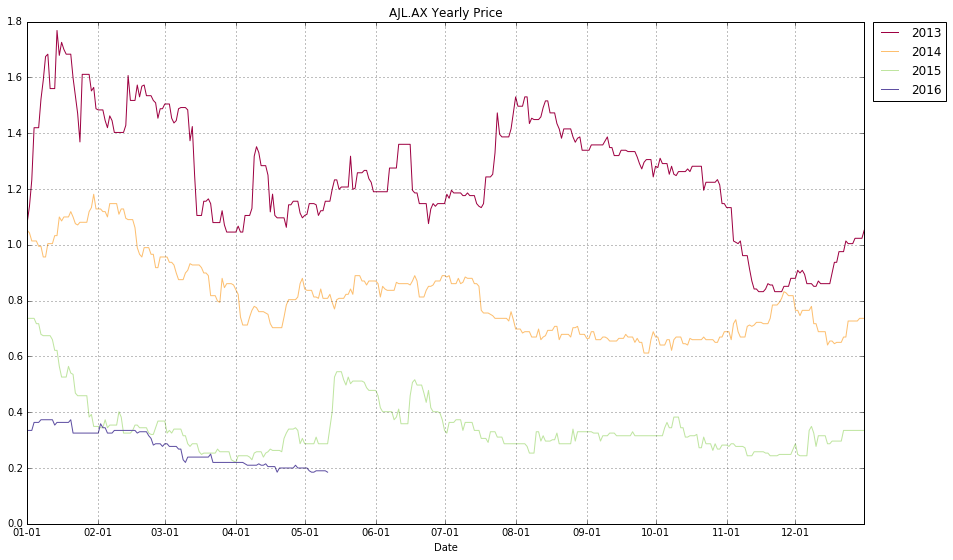

In [15]:
plt.figure(figsize=(15, 9))
ax = None
for year_ind, year in enumerate(years):
    if ax:
        ax = price.loc[:, year].plot(label=year, color=colors[year_ind], ax=ax)
    else:
        ax = price.loc[:, year].plot(label=year, color=colors[year_ind])
y = ax.get_ylim()
if not div_dat.empty:
    div_dates = div_dat.index.tolist()
    for div_date in div_dates:
        x = [date_str.index('{:02d}-{:02d}'.format(div_date.month, div_date.day))] * 2
        ax.plot(x, y, color=colors[years.index(div_date.year)], linestyle='-')
plt.title(code + ' Yearly Price')
plt.xticks(xlocs, xticks)
plt.grid()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.savefig(code+'yearlyPrice.png')